<a href="https://colab.research.google.com/github/Frsagco/ML_denoising/blob/main/ML_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto Machine Learning

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras import Sequential, Model, Input, utils
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.optimizers import Adam

from keras.initializers import RandomNormal
from scipy.stats import norm, bernoulli, poisson
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
import scipy.stats as stats


## Import dataset BSD

In [2]:
import pathlib
dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='BSDS300',
                                   untar=True)

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('images/*/*.jpg')))
image_count_train = len(list(data_dir.glob('images/train/*.jpg')))
image_count_test = len(list(data_dir.glob('images/test/*.jpg')))

print(image_count)

test_temp = list(data_dir.glob('images/test/*'))
train_temp = list(data_dir.glob('images/train/*'))

22224896/22211847 [==============================] - 1s 0us/step
300


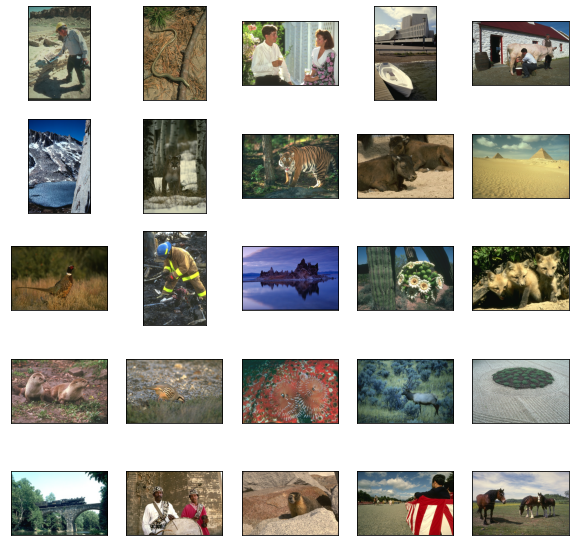

In [3]:
#codice per mostrare alcuni esempi
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(PIL.Image.open(str(test_temp[i])), cmap=plt.cm.binary)
   
plt.show()

Codice per salvare le immagini in due array


*   Array di matrici RGB 
*   Array di oggetti immagine

Eseguiamo il crop delle immagini

In [4]:
n=256

test_as_img = []
test_as_arr = []
for i in range(image_count_test):
  image=cv2.imread(str(test_temp[i]))
  image=image[0:n,0:n,0:3]
  test_as_img.append(image)
  image=np.array(image, dtype = 'uint8')
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  test_as_arr.append(image)
  
train_as_img=[]
train_as_arr=[]
for i in range(image_count_train):
  image=cv2.imread(str(train_temp[i]))
  image=image[0:n,0:n,0:3]
  train_as_img.append(image)
  image=np.array(image, dtype = 'uint8')
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  train_as_arr.append(image)

image_size=[n,n,3]
print(image_size)


[256, 256, 3]


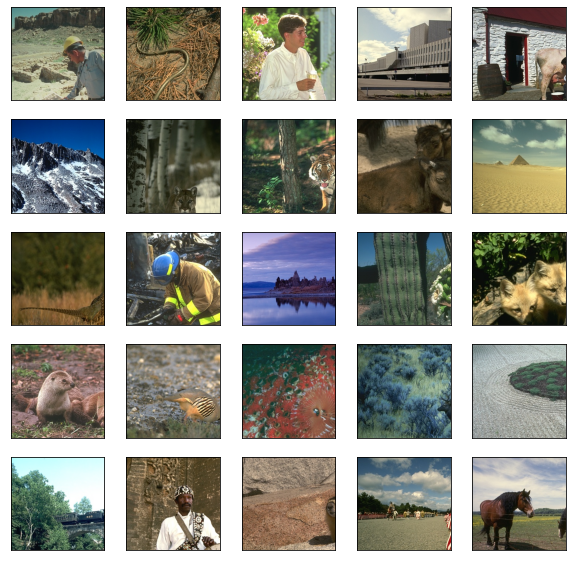

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_as_arr[i], cmap=plt.cm.binary)
   
plt.show()

## Adding Noise

In [6]:
def truncnorm_(lower, upper, sigma):
  mu = (lower+upper)/2

  X = np.random.normal(mu, sigma)

  if(X < lower):
    return lower
  if(X > upper):
    return upper

  return X

In [68]:
def apply_noise_to_image(img):
  noise_choises=["gaussian", "s&p", "speckle"];
  index=np.random.randint(0,3);

  if noise_choises[index]=="gaussian":
    mean=0;

    lower, upper = 0.005, 0.03
    sigma = 0.005
    var=truncnorm_(lower, upper, sigma)
    
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=var)

  elif noise_choises[index]=="s&p":
    lower, upper = 0.02, 0.07
    sigma = 0.01

    amount=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='s&p', amount=amount)

  elif noise_choises[index]=="speckle":
    lower, upper = 0.005, 0.02
    sigma = 0.003

    var=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='speckle', var=var)

  else:
    print('PANIC: Wrong noise index.')
    return
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  noise_img_rgb = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
  return noise_img_rgb #random_noise returns [0,1] or [-1,1] value

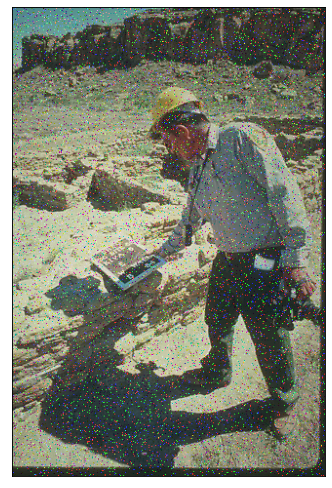

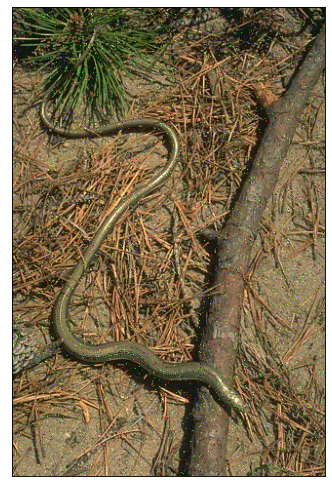

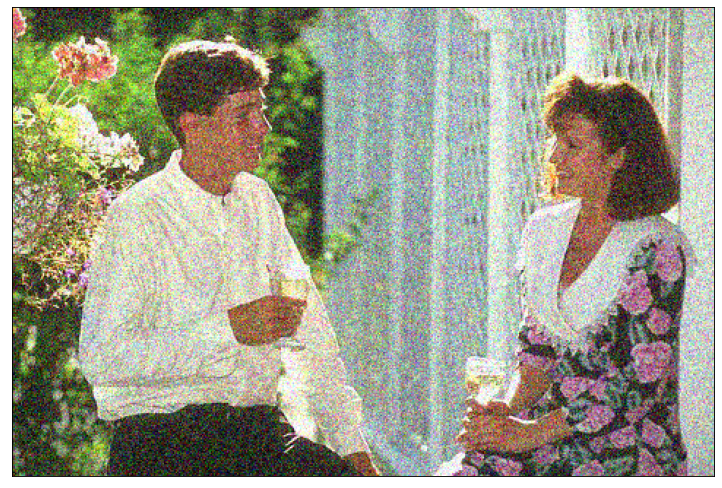

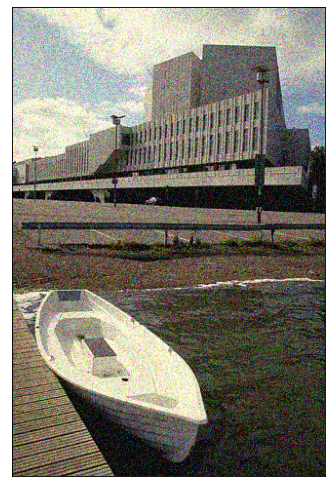

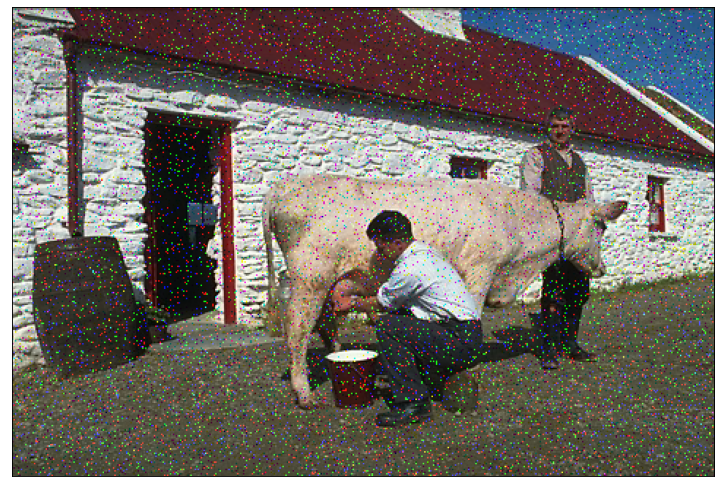

In [8]:
from matplotlib import pyplot as plt

for i in range(5):
    plt.figure(figsize=(50,45), dpi=80)

    img = cv2.imread(str(test_temp[i]))
    noise_img=apply_noise_to_image(img)
    noise_img=np.array(noise_img, dtype = 'uint8')
    noise_img_rgb=cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)

    plt.subplot(5,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((noise_img_rgb), cmap=plt.cm.binary)
   
plt.show()

## Generatore - Discriminatore 

In [172]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [173]:
image_shape=image_size
print(image_size)

[256, 256, 3]


In [174]:
from numpy.core.fromnumeric import resize
def define_generator(image_shape):
  # weight initialization

  init = RandomNormal(stddev=0.02)

  # image input
  in_image = Input(shape=image_shape)
  # encoder model
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  #e7 = define_encoder_block(e6, 512)
  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e6)
  b = Activation('relu')(b)
  # decoder model
  # d1 = decoder_block(b, e7, 512)
  # d2 = decoder_block(d1, e6, 512)
  # d3 = decoder_block(d2, e5, 512)
  # d4 = decoder_block(d3, e4, 512, dropout=False)
  # d5 = decoder_block(d4, e3, 256, dropout=False)
  # d6 = decoder_block(d5, e2, 128, dropout=False)
  # d7 = decoder_block(d6, e1, 64, dropout=False)
  d1 = decoder_block(b, e6, 512)
  d2 = decoder_block(d1, e5, 512)
  d3 = decoder_block(d2, e4, 512)
  d4 = decoder_block(d3, e3, 256, dropout=False)
  d5 = decoder_block(d4, e2, 128, dropout=False)
  d6 = decoder_block(d5, e1, 64, dropout=False)


  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6)
  out_image = Activation('tanh')(g)
  # define model
  model = Model(in_image, out_image)
  return model

In [175]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image= Input(shape=image_shape)
	# target image input
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	# d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	# d = BatchNormalization()(d)
	# d = LeakyReLU(alpha=0.2)(d)

	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [176]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	print(in_src.shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model


In [177]:
d_model.summary()

Model: "model_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_100 (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_444 (Conv2D)         (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_378 (LeakyReLU)  (None, 128, 128, 64)     0         
                                                                 
 conv2d_445 (Conv2D)         (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_534 (Ba  (None, 64, 64, 128)      512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_379 (LeakyReLU)  (None, 64, 64, 128)      0         
                                                          

In [178]:
g_model.summary()

Model: "model_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_101 (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_449 (Conv2D)         (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_382 (LeakyReLU)  (None, 128, 128, 64)     0         
                                                                 
 conv2d_450 (Conv2D)         (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_537 (Ba  (None, 64, 64, 128)      512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_383 (LeakyReLU)  (None, 64, 64, 128)      0         
                                                         

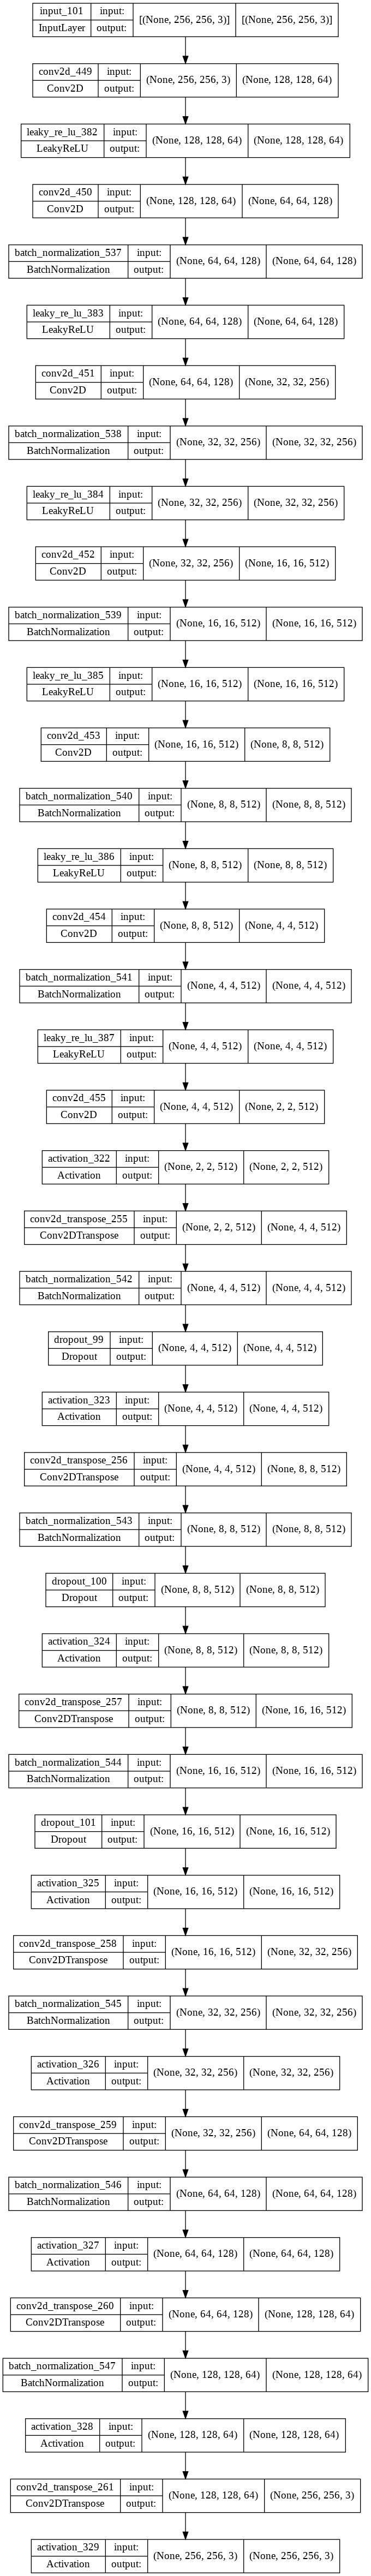

In [179]:
keras.utils.plot_model(g_model, "Generator.jpg", show_shapes=True)

In [180]:
gan_model.summary()

Model: "model_101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_102 (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_100 (Functional)         (None, 256, 256, 3)  30697091    ['input_102[0][0]']              
                                                                                                  
 model_99 (Functional)          (None, 16, 16, 1)    2768321     ['input_102[0][0]',              
                                                                  'model_100[0][0]']              
                                                                                          

In [181]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [182]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
  # choose random instances
  ix = np.random.randint(0, image_count_train, n_samples)
  ix = np.array(ix).astype(int)
  X = np.zeros((n_samples, 256, 256, 3))
  # retrieve selected images
  for i in range(n_samples):
    X[i]=train_as_arr[ix[i]]
  # generate 'real' class labels (1)
  y = np.ones((n_samples, patch_shape, 1))
  return X , y, ix
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, ix, n_samples, patch_shape):
  # generate fake instance
  samples = np.zeros((n_samples, 256, 256, 3))
  for i in range(n_samples):
    samples[i]=apply_noise_to_image(train_as_img[ix[i]])

  print("Samples:")
  print(n_samples)
  X = g_model.predict(samples)
  print("FakeSamples:")
  print(X.shape)
  # create 'fake' class labels (0)
  y = np.zeros((len(X), patch_shape, patch_shape, 1))
  return X , y

In [183]:
ix = np.random.randint(0, image_count_train, 2)
ix = np.array(ix).astype(int)
X = [0,0]
print(ix)
for i in range(2):
  print(ix[i])
  X[i] = train_as_arr[ix[i]]
#X = train_as_arr[ix]

[  9 114]
9
114


In [184]:
# train pix2pix models
def train_(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	train = dataset

	# calculate the number of batches per training epoch
	bat_per_epo = int(image_count_train / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_real, y_real, ix = generate_real_samples(dataset, n_batch, n_patch)

		# generate a batch of fake samples
		X_gen, y_fake = generate_fake_samples(g_model, ix, n_batch, n_patch)
		# update discriminator for original samples
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		print("DDDDDDD")

		# update discriminator for noisy samples
		d_loss2 = d_model.train_on_batch(X_gen, y_fake)
		print("EEEEEEEEEE")
		# update the generator
		print(X_real.shape)
		#print(y)
		# g_loss, _, _ = gan_model.train_on_batch(X_real, [y_real, X_gen])
		g_loss, _, _ = gan_model.train_on_batch(X_gen)
		
		print("FFFFFF")
		
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [185]:
dataset = train_as_arr
print(dataset[0].shape)
# define the models
d_model = define_discriminator(image_size)
g_model = define_generator(image_size)
# define the composite model
gan_model = define_gan(g_model, d_model, image_size)
# train model
train_(d_model, g_model, gan_model, dataset, n_batch=1)

(256, 256, 3)
(None, 256, 256, 3)
Samples:
1
FakeSamples:
(1, 256, 256, 3)
DDDDDDD
EEEEEEEEEE
(1, 256, 256, 3)


ValueError: ignored